<a href="https://colab.research.google.com/github/xTrunic/2017-JMLR-MCMCForTallData/blob/master/MCMCForTallData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the code of Bardenet: https://github.com/rbardenet/2017-JMLR-MCMCForTallData


In [ ]:
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import scipy.special as spsp
import scipy.misc as spm
import scipy.optimize as spo
import numpy.linalg as npl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sympy as sym
import time
import seaborn as sns
import seaborn.distributions as snsd
import math as math
# sns.set(style="ticks");
# plt.ioff() # turn off interactive plotting
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# mpl.rcParams['xtick.labelsize'] = 22
# mpl.rcParams['ytick.labelsize'] = 22
# plt.rc('axes', labelsize=22)
# plt.rc('legend', fontsize=22)
#mpl.rcParams['ps.useafm'] = True
##mpl.rcParams['pdf.use14corefonts'] = True
#mpl.rcParams['text.usetex'] = True
npr.seed(1)

We will save Figures in the following directory, by default it is the current directory.

In [ ]:
saveDirStr = ""

## Generate Toy Data

First, let us generate some data. Change variable "dataType" to switch between the Gaussian and the lognormal examples from the paper.

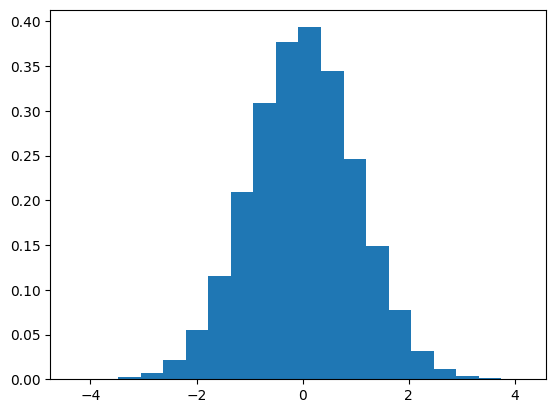

Mean of x = 0.005253028489682668
Std of x = 0.9983292735417362


In [ ]:
# Generate data
npr.seed(1)
N = 100000
dataType = "Gaussian"
#dataType = "logNormal"
if dataType == "Gaussian":
    x = npr.randn(N)
elif dataType == "logNormal":
    x = npr.lognormal(0,1,size=N)
plt.clf()
plt.hist(x, 20, density=True)
plt.show()

# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = np.mean(x)
realStd = np.std(x)
print(f"Mean of x = {realMean}")
print(f"Std of x = {realStd}")

We are going to estimate the mean and std deviation of a Gaussian model, applied to the toy dataset generated above.


In [ ]:
def getLogLhd(x, mu, sigma):
    """
    return an array of Gaussian log likelihoods up to a constant
    """
    return -(x-mu)**2/(2*sigma**2) - np.log(sigma)

In [ ]:
def combineMeansAndSSQs(N1, mu1, ssq1, N2, mu2, ssq2):
    """
    combine means and sum of squares of two sets
    """
    dd = mu2 - mu1
    mu = mu1
    ssq = ssq1
    N = N1+N2
    mu += dd*N2/N
    ssq += ssq2
    ssq += (dd**2) * N1 * N2 / N
    return N, mu, ssq

The following function plots the results as in the paper. It is a bit messy, but you can safely skip this cell without missing anything on the algorithms.

In [ ]:
def plotResults(sample,
                sample_ref,
                realMean: float,
                realStd: float,
                algoName: str = "doesNotMatter",
                boolSave: bool = False,
                figId: str = "basic"):
    """
    Plot Mean and Std of a sample in a Jointplont.

    Sample with blue histogram in the marginals and a joined hex plot.
    Add Bernstein von Misses Approximation in red dotted line.
    Add Reference Sample with Green line
    Args:
      sample:
        2D Array with all samples for mu in sample[:,0] and sigma in sample[:,1]
      sample_ref:
        2D Array with all ref samples for mu in sample[:,0] and sigma in sample[:,1]
      algoName:
        Name of the algorithm used for saving

    """
    s_mu = sample[:,0] # Sample of Means
    s_ref_mu = sample_ref[:,0] # Sample of Stds
    N = len(sample) # Number of samples

    s_sig = np.exp(sample[:,1])
    s_ref_sig = np.exp(sample_ref[:,1])
    # Precompute limits for x
    s_min = np.min(s_mu)
    s_max = np.max(s_mu)
    s_ref_min = np.min(s_ref_mu)
    s_ref_max = np.max(s_ref_mu)

    xlimInf = min(s_min, s_ref_min)
    xlimSup = max(s_max, s_ref_max)
    print(f"xlims = {xlimInf}, {xlimSup}")
    xPlot = np.linspace(xlimInf, xlimSup, 1000)
    # Precompute limits for y
    s_min = np.min(s_sig)
    s_max = np.max(s_sig)
    s_ref_min = np.min(s_ref_sig)
    s_ref_max = np.max(s_ref_sig)

    ylimInf = min(s_min, s_ref_min)
    ylimSup = max(s_max, s_ref_max)
    print(f"ylims = {ylimInf}, {ylimSup}")
    yPlot = np.linspace(ylimInf, ylimSup, 1000)

    #Create jointplot with sample
    g = sns.jointplot(x = s_mu,y = s_sig,
                      kind="hex",
                      space=0, height=10,
                      xlim=(xlimInf,xlimSup), ylim=(ylimInf,ylimSup),
                      marginal_kws=dict())
    plt.sca(g.ax_joint)
    plt.xlabel("$\mu$",)
    plt.ylabel("$\sigma$")

    # Add Reference long MH draw
    # ... to joint plot
    sns.kdeplot(x = s_ref_mu, y = s_ref_sig,
                ax=g.ax_joint,
                bw_method="silverman",
                cmap="BuGn_r",
                linewidth = 6)
    # ... to the marginal plots
    marg_mu = sps.gaussian_kde(s_ref_mu)
    marg_sig = sps.gaussian_kde(s_ref_sig)

    g.ax_marg_x.plot(xPlot, marg_mu(xPlot), 'g', linewidth=3, label="Ref")
    g.ax_marg_y.plot(marg_sig(yPlot), yPlot, 'g', linewidth=3)

    #Bernstein von Mises approximation
    #Compute Bernstein von Mises approximations
    minusFisher = np.array([[1/realStd**2, 0],[0, 2/realStd**2]])
    asym_var = 1/N*npl.inv(minusFisher)
    # Add Bernstein von Mises approximations
    # ... to the joint plot
    X, Y = np.meshgrid(xPlot, yPlot)
    bvM = sps.multivariate_normal([realMean, realStd], np.sqrt(asym_var)).pdf(np.dstack((X, Y)))
    print(realMean, np.sqrt(asym_var[0,0]))
    bvM_mu = sps.norm(100, 1).pdf(xPlot)
    bvM_sig = sps.norm(realStd, np.sqrt(asym_var[1,1])).pdf(yPlot)
    g.ax_joint.contour(X, Y, -bvM, 1,
                       colors="r",
                       label="BvM",
                       linestyle='--', linewidth=(6)
                       )
    # # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, bvM_mu
                    ,color="red"
                    ,label="BvM"
                    ,linestyle='--', linewidth=6
                    )
    g.ax_marg_y.plot(bvM_sig, yPlot
                     ,color="red"
                     ,linestyle='--', linewidth=6
                     )

    # Print legend and save
    g.ax_marg_x.legend()
    save_path = f"{saveDirStr}chain_{dataType}_{algoName}_{figId}.pdf"
    print(save_path)

    if boolSave:
        plt.savefig(save_path)
    plt.show()

    # # Plot autocorr of second component
    # c = plt.acorr(np.exp(S[:,1]), maxlags=50, detrend=detrend_mean, normed=True)
    # plt.clf()
    # c = c[1][c[0]>=0]
    # plt.plot(c, linewidth=3)
    # plt.plot(c_ref, label="Ref", linewidth=3, color="g")
    # plt.grid(True)

    # plt.legend(loc=1)
    # if boolSave:
    #         plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".pdf")
    #         plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".eps")

    # Plot average number of likelihoods computed
    # if not algoName =="vanillaMH":
    #     plt.hist(ns, histtype="stepfilled", alpha=.3)
    #     labStr = "mean="+str(np.around(1.0*np.mean(ns)/N*100,1))+"\%"
    #     plt.axvline(np.mean(ns), linewidth = 4, color="blue", label=labStr)
    #     labStr = "median="+str(np.around(1.0*np.median(ns)/N*100,1))+"\%"
    #     print(f"Median= {np.median(ns)}")
    #     plt.axvline(np.median(ns), linewidth = 4, color="blue",linestyle='--', label=labStr)
    #     plt.axvline(N, linewidth = 4, color="k", label="n")
    #     plt.xlim([0, 2*N+1])
    #     plt.legend()
    #     if boolSave:
    #         plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".pdf")
    #         plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".eps")
    #         print("Plots saved")
    #     plt.show()

In [ ]:
print(sps.norm(0.1, 1).pdf(np.linspace(-1,1,100)))

[0.21785218 0.22270208 0.22756706 0.23244343 0.23732741 0.24221514
 0.24710266 0.25198595 0.25686088 0.2617233  0.26656894 0.27139351
 0.27619266 0.28096198 0.28569704 0.29039335 0.29504643 0.29965174
 0.30420476 0.30870095 0.31313577 0.31750469 0.32180321 0.32602683
 0.33017112 0.33423164 0.33820405 0.34208403 0.34586734 0.3495498
 0.35312732 0.3565959  0.3599516  0.36319063 0.36630928 0.36930395
 0.37217119 0.37490765 0.37751012 0.37997555 0.38230103 0.38448379
 0.38652124 0.38841092 0.39015059 0.39173814 0.39317165 0.3944494
 0.39556982 0.39653156 0.39733344 0.39797449 0.39845393 0.39877116
 0.3989258  0.39891766 0.39874674 0.39841327 0.39791765 0.39726048
 0.39644256 0.3954649  0.39432868 0.39303528 0.39158629 0.38998344
 0.38822867 0.3863241  0.38427201 0.38207486 0.37973526 0.37725599
 0.37463998 0.3718903  0.36901017 0.36600294 0.36287209 0.35962122
 0.35625405 0.35277441 0.34918621 0.34549348 0.34170031 0.3378109
 0.33382948 0.32976038 0.32560797 0.32137665 0.31707089 0.3126951

In [ ]:
def vanillaMH(T):
    """
    perform traditional isotropic random walk Metropolis
    """
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .5/np.sqrt(N)
    S = np.zeros((T, 2))
    acceptance = 0.0

    for i in range(T):
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        Lambda = np.mean(lhds)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta

        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))

        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            print("Iteration", i, "Acceptance", acceptance)

    return S

In [ ]:
# Compute good marginals using a long run for later comparisons
S_ref = vanillaMH(5000)
#c = plt.acorr(np.exp(S_ref[:,1]), maxlags=50, detrend=detrend_mean, density=True);
#c_ref = c[1][c[0]>=0]
#plt.show()

Iteration 0 Acceptance 0.0
Iteration 500 Acceptance 0.5049900199600798
Iteration 1000 Acceptance 0.48251748251748244
Iteration 1500 Acceptance 0.47968021319120585
Iteration 2000 Acceptance 0.47976011994003
Iteration 2500 Acceptance 0.48340663734506195
Iteration 3000 Acceptance 0.4808397200933022
Iteration 3500 Acceptance 0.48414738646101113
Iteration 4000 Acceptance 0.4793801549612597
Iteration 4500 Acceptance 0.4798933570317707


In [ ]:
S = vanillaMH(1000)

Iteration 0 Acceptance 1.0
Iteration 100 Acceptance 0.5346534653465346
Iteration 200 Acceptance 0.5124378109452735
Iteration 300 Acceptance 0.5083056478405318
Iteration 400 Acceptance 0.4688279301745636
Iteration 500 Acceptance 0.47904191616766467
Iteration 600 Acceptance 0.480865224625624
Iteration 700 Acceptance 0.47503566333808844
Iteration 800 Acceptance 0.46691635455680397
Iteration 900 Acceptance 0.47613762486126526


xlims = -0.004796218505493647, 0.016106906057877117
ylims = 0.9908826580546191, 1.0061560630829471


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


0.005253028489682668 0.0315699435921316
chain_Gaussian_doesNotMatter_basic.pdf


<ipython-input-59-75d9f47b9c6e>:85: UserWarning: The following kwargs were not used by contour: 'label', 'linestyle', 'linewidth'
  g.ax_joint.contour(X, Y, -bvM, 1,


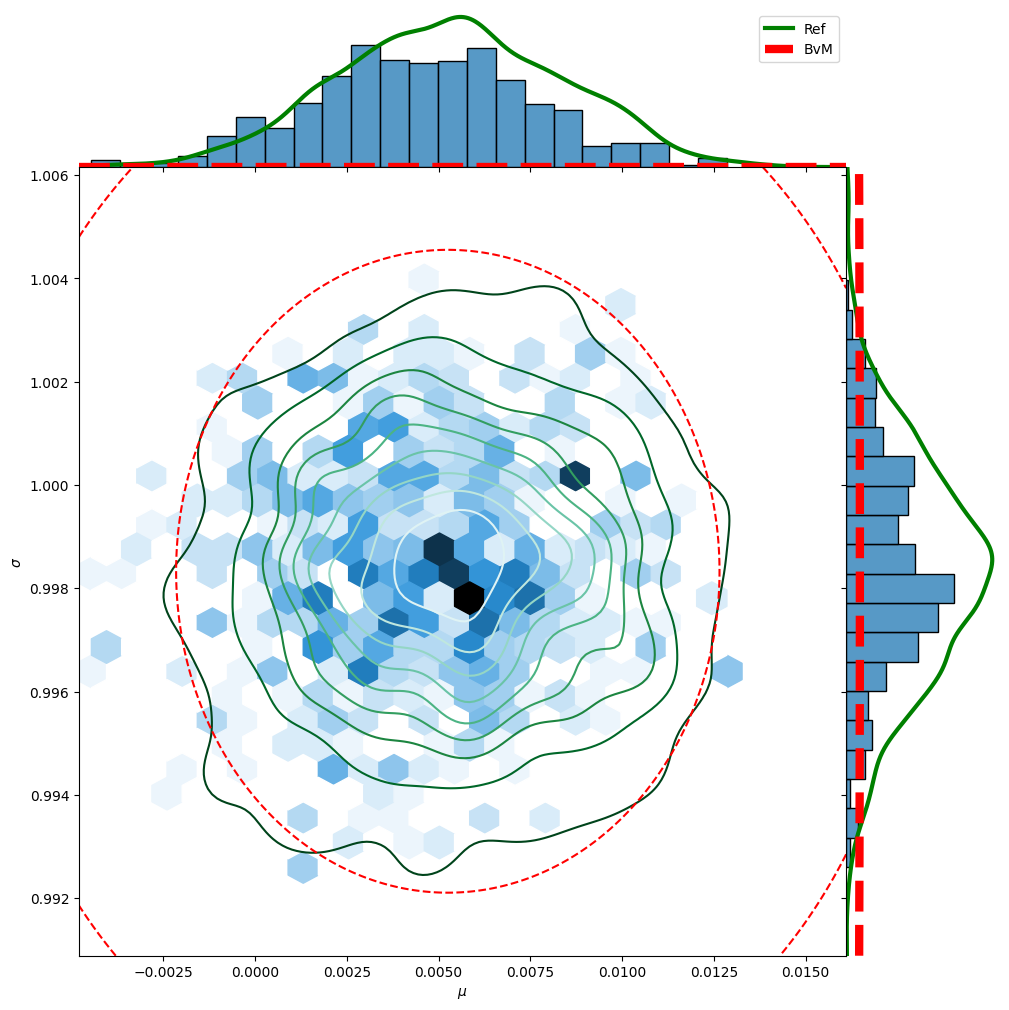

In [ ]:
plotResults(S,S_ref, realMean= realMean, realStd = realStd, boolSave=0)